<a href="https://colab.research.google.com/github/mrpep/my-colabs/blob/master/Contextualized_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#@title Instalar dependencias e importarlas
!pip install transformers
!pip install simpletransformers
import torch
import transformers
import sys
import seaborn as sns
import numpy as np
import pandas as pd
import tqdm

from simpletransformers.classification import ClassificationModel

#!git clone https://github.com/NVIDIA/apex
#%cd apex
#!pip uninstall apex # repeat until you're sure it's gone
#!pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./
#%cd ..

Primero vamos a observar como tokeniza BERT los textos de entrada. Recordemos que usa WordPieces, por ende, puede representar palabras como una secuencia de sub-palabras:

In [0]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
test_text = "BERT is a pretrained language model that achieves state of the art results in many natural language processing tasks"
tokenized_text = tokenizer.tokenize(test_text)
print(tokenized_text)


['bert', 'is', 'a', 'pre', '##train', '##ed', 'language', 'model', 'that', 'achieve', '##s', 'state', 'of', 'the', 'art', 'results', 'in', 'many', 'natural', 'language', 'processing', 'tasks']


Efectivamente "pretrained" fue descompuesto en 3 sub-palabras: "pre", "train" y "ed", lo cual tiene mucho sentido. Del mismo modo, "achieves" fue descompuesto en "achieve" y "s".

A su vez, debemos manejar los tokens especiales de BERT ([CLS], [SEP] y [MASK]):

In [0]:
def encode_bert_sentence(sentence, tokenizer):
  if '[MASK]' in sentence:
    unmasked_subsentences = sentence.split('[MASK]')
    unmasked_tokens = []
    for subsentence in unmasked_subsentences:
      unmasked_tokens = unmasked_tokens + tokenizer.tokenize(subsentence) + ['[MASK]']
    unmasked_tokens.pop(-1)
  else:
    unmasked_tokens = tokenizer.tokenize(sentence)

  return unmasked_tokens

def prepare_bert_input_tokens(text, tokenizer):
  sentence_tokens = []
  sentences = text.split('[SEP]')
  for sentence in sentences:
    if sentence != '':
      encoded_sentence = encode_bert_sentence(sentence, tokenizer)
      sentence_tokens = sentence_tokens + encoded_sentence + ['[SEP]']
  sentence_tokens.insert(0,'[CLS]')
  return sentence_tokens

In [0]:
tokenized_test_text = prepare_bert_input_tokens(test_text, tokenizer)
print(tokenized_test_text)

['[CLS]', 'bert', 'is', 'a', 'pre', '##train', '##ed', 'language', 'model', 'that', 'achieve', '##s', 'state', 'of', 'the', 'art', 'results', 'in', 'many', 'natural', 'language', 'processing', 'tasks', '[SEP]']


A continuación vamos a jugar con BERT de varias maneras:



# Modelo de lenguaje enmascarado

Lo primero que vamos a hacer es testear a BERT en una de las tareas con las que fue entrenado de manera no supervisada: predecir la palabra enmascarada (con el token [MASK]).

Primero enmascaramos la palabra "language"

In [0]:
masked_index = 7
tokenized_test_text[masked_index] = '[MASK]'
print(tokenized_test_text)

['[CLS]', 'bert', 'is', 'a', 'pre', '##train', '##ed', '[MASK]', 'model', 'that', 'achieve', '##s', 'state', 'of', 'the', 'art', 'results', 'in', 'many', 'natural', 'language', 'processing', 'tasks', '[SEP]']


Ahora tenemos que codificar cada token. Podemos ver cada palabra que id tiene accediendo al diccionario vocab del tokenizer:

In [0]:
tokenizer.vocab['art']

2396

Luego podemos encodear la frase completa.

In [0]:
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_test_text)
print(indexed_tokens)

[101, 14324, 2003, 1037, 3653, 23654, 2098, 103, 2944, 2008, 6162, 2015, 2110, 1997, 1996, 2396, 3463, 1999, 2116, 3019, 2653, 6364, 8518, 102]


A su vez, recordemos que BERT también aprende sentence embeddings de entrada, los cuales se suman al embedding posicional y al embedding de cada palabra, por ende debemos armar un vector que indique para cada palabra si pertenece a la primer oración o a la segunda.

In [0]:
def get_sentence_ids(tokens):
  if "[SEP]" in tokens:
    sep_idxs = [i for i,token in enumerate(tokens) if token == "[SEP]"]
    sentence_ids = [0,]*(sep_idxs[0]+1) + [1,]*(len(tokens)-(sep_idxs[0]+1))
  else:
    sentence_ids = [0,]*len(tokens)

  return sentence_ids

sentence_ids = get_sentence_ids(tokenized_test_text)
print(sentence_ids)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Armamos tensores de PyTorch

In [0]:
tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([sentence_ids])

Abrimos el modelo de lenguaje enmascarado:

In [0]:
# Load pre-trained model (weights)
masked_model = transformers.BertForMaskedLM.from_pretrained('bert-base-uncased',output_attentions=True)
masked_model.eval()

# If you have a GPU, put everything on cuda
tokens_tensor = tokens_tensor.to('cuda')
segments_tensors = segments_tensors.to('cuda')
masked_model.to('cuda')

# Predict all tokens
with torch.no_grad():
    predictions = masked_model(tokens_tensor, segments_tensors)

Lo que obtuvimos (prediction) es una tupla (logits,pesos de atencion). Ahora vamos a ver para el índice que enmascaramos cuáles son las palabras más probables según el modelo de lenguaje enmascarado de BERT.

In [0]:
v, k = predictions[0][0,masked_index,:].topk(10)
predicted_tokens = tokenizer.convert_ids_to_tokens(k.flatten().tolist())
predicted_tokens

['learning',
 'language',
 'cognitive',
 'programming',
 'ai',
 'computational',
 'computer',
 'software',
 'linguistic',
 'mathematical']

Bastante bien! "Language" aparece segundo, y las demás palabras tienen sentido en el contexto. Sobre todo teniendo en cuenta que el corpus con el que se entrenó BERT no tenía a la BERT asociada al modelo de lenguaje sino que al personaje de plaza sésamo. Entonces podríamos hacer un pequeño experimento:


In [0]:
def bert_predict(text,tokenizer,model):
  tokenized_text = prepare_bert_input_tokens(text, tokenizer)
  if '[MASK]' in tokenized_text:
    mask_idx = tokenized_text.index('[MASK]')
  
  indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
  sentence_ids = get_sentence_ids(tokenized_text)

  tokens_tensor = torch.tensor([indexed_tokens])
  segments_tensors = torch.tensor([sentence_ids])

  model.eval()

  tokens_tensor = tokens_tensor.to('cuda')
  segments_tensors = segments_tensors.to('cuda')

  model.to('cuda')

  with torch.no_grad():
    predictions = model(tokens_tensor)

  return predictions, tokenized_text

def get_top_bert_predictions(text,tokenizer,model,top_k=10):

  predictions, tokenized_text = bert_predict(text,tokenizer,model)

  if '[MASK]' in tokenized_text:
    mask_idx = tokenized_text.index('[MASK]')
    v, k = predictions[0][0,mask_idx,:].topk(top_k)
    predicted_tokens = tokenizer.convert_ids_to_tokens(k.flatten().tolist())
  else:
    predicted_tokens = None

  return tokenized_text,predicted_tokens,predictions


In [0]:
new_text = "Word2vec is a pretrained [MASK] model that achieves state of the art results in many natural language processing tasks"
tokenized_text,predicted,predictions = get_top_bert_predictions(new_text,tokenizer,masked_model)
predicted

['language',
 'learning',
 'programming',
 'computer',
 'linguistic',
 'cognitive',
 'software',
 'communication',
 'neural',
 'computational']

Efectivamente, Word2VEC estaba dentro del corpus usado para entrenar a BERT, y este gigantesco modelo pudo incorporar el conocimiento de que es un modelo de lenguaje (todo esto es una hipótesis muy dificil de probar :p)

¿Qué más podemos hacer con BERT?

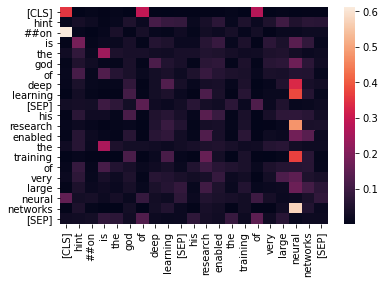

In [0]:
#@title Visualización de los pesos de atención

text = "Hinton is the god of deep learning [SEP] His research enabled the training of very large neural networks" #@param {type:"string"}
attention_head = 2 #@param {type:"slider", min:1, max:12, step:1}
layer = 1 #@param {type:"slider", min:1, max:12, step:1}

tokenized_text,_,predictions = get_top_bert_predictions(text,tokenizer,masked_model)

attention_head = predictions[1][layer-1][0,attention_head-1,:,:].cpu().numpy()
sns.heatmap(attention_head,xticklabels=tokenized_text,yticklabels=tokenized_text)


Se puede ver que cada cabeza de atención capta distintas relaciones. Algunas aprenden patrones en diagonal (se prestan atención a si mismas y no contextualizan. Otras toman diagonales con algunos elementos cercanos (contextos cortos). Otras aprenden coreferencias. La que está ploteada es interesante: "neural" es asociado a "networks", "training", "research", "deep" y "learning"

# Clasificación de texto
## Sentiment140

Vamos a usar el dataset Sentiment140 para hacer sentiment analysis. Lo descargamos y extraemos.



In [0]:
!wget http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
!unzip trainingandtestdata.zip

--2020-05-31 20:11:04--  http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
Resolving cs.stanford.edu (cs.stanford.edu)... 171.64.64.64
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip [following]
--2020-05-31 20:11:05--  https://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81363704 (78M) [application/zip]
Saving to: ‘trainingandtestdata.zip’

trainingandtestdata 100%[===================>]  77.59M  56.5MB/s    in 1.4s    

2020-05-31 20:11:06 (56.5 MB/s) - ‘trainingandtestdata.zip’ saved [81363704/81363704]

Archive:  trainingandtestdata.zip
  inflating: testdata.manual.2009.06.14.csv  
  inflating: training.1600000.processed.noemoticon.csv  


In [0]:
training_set = pd.read_csv('training.1600000.processed.noemoticon.csv',encoding = "ISO-8859-1",header=None,names=['Polarity','id','Date','Query','User','Text'])
training_set.head()

,Polarity,id,Date,Query,User,Text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


What is the format of the training data?
The data is a CSV with emoticons removed. Data file format has 6 fields:

* 0 - the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
* 1 - the id of the tweet (2087)
* 2 - the date of the tweet (Sat May 16 23:58:44 UTC 2009)
* 3 - the query (lyx). If there is no query, then this value is NO_QUERY.
* 4 - the user that tweeted (robotickilldozr)
* 5 - the text of the tweet (Lyx is cool)

Analicemos el balance de clases:

In [0]:
training_set['Polarity'].value_counts()

4    800000
0    800000
Name: Polarity, dtype: int64

Solamente hay positivo (4) y negativo (0). El dataset está balanceado.

Vamos a trabajar con un subset más chico (10000 muestras positivas y 10000 negativas):

In [0]:
positive_samples = training_set[training_set['Polarity'] == 4].sample(10000)
negative_samples = training_set[training_set['Polarity'] == 0].sample(10000)
training_subset = pd.concat([positive_samples,negative_samples],axis=0)

training_subset = training_subset.drop(columns=['id','Date','Query','User'])

mapping_dict = {0:0, 4:1}
training_subset['Polarity'] = training_subset['Polarity'].apply(lambda x : mapping_dict[x])
training_subset = training_subset.rename({'Polarity':'labels','Text':'text'},axis=1)

También vamos a cargar los datos de evaluación. Es interesante que, a diferencia de en el set de entrenamiento, posee también un label "neutro". Como no estaba esta categoría en el set de entrenamiento vamos a omitirla:

In [0]:
eval_set = pd.read_csv('testdata.manual.2009.06.14.csv',encoding = "ISO-8859-1",header=None,names=['Polarity','id','Date','Query','User','Text'])
eval_set.head()

mapping_dict = {0:0, 2:-1, 4:1}
eval_set['Polarity'] = eval_set['Polarity'].apply(lambda x : mapping_dict[x])
eval_set = eval_set.rename({'Polarity':'labels','Text':'text'},axis=1)
eval_set = eval_set.drop(columns=['id','Date','Query','User'])
eval_set = eval_set[eval_set['labels'] != -1]


## Baseline FastText + GRUs

In [0]:
!pip install fasttext

     |████████████████████████████████| 71kB 2.5MB/s 
  Created wheel for fasttext: filename=fasttext-0.9.2-cp36-cp36m-linux_x86_64.whl size=3018080 sha256=7c39d841bc05735d22e56a9c8d24ad3b6a5951c54e7796a42351f6f1b582104e
  Stored in directory: /root/.cache/pip/wheels/98/ba/7f/b154944a1cf5a8cee91c154b75231136cc3a3321ab0e30f592
Successfully built fasttext


Descargamos el modelo de FastText preentrenado en CommonCrawl:

In [0]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M-subword.zip
!unzip crawl-300d-2M-subword.zip

--2020-05-31 20:12:45--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M-subword.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 104.22.74.142, 2606:4700:10::6816:4b8e, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5828358084 (5.4G) [application/zip]
Saving to: ‘crawl-300d-2M-subword.zip’

crawl-300d-2M-subwo 100%[===================>]   5.43G  25.0MB/s    in 3m 42s  

2020-05-31 20:16:28 (25.0 MB/s) - ‘crawl-300d-2M-subword.zip’ saved [5828358084/5828358084]

Archive:  crawl-300d-2M-subword.zip
  inflating: crawl-300d-2M-subword.vec  
  inflating: crawl-300d-2M-subword.bin  


In [0]:
import fasttext
import numpy as np
import tensorflow as tf

In [0]:
ft_model = fasttext.load_model('crawl-300d-2M-subword.bin')

Pasamos el dataframe a arrays de numpy para armar los datasets:

In [0]:
def df_to_np(df):
  x = []
  y = []
  for logid, row in tqdm.tqdm(df.iterrows()):
    ft_embeddings = np.expand_dims(np.array([ft_model.get_word_vector(word) for word in row['text'].lower().split()]),axis=0)
    x.append(ft_embeddings)
    y.append(row['labels'])

  return x,y

x_train, y_train = df_to_np(training_subset)
x_eval, y_eval = df_to_np(eval_set)

20000it [00:04, 4089.25it/s]
359it [00:00, 3843.33it/s]


Esto es un generador, nos permite trabajar con datasets muy grandes sin estar limitados por la RAM. También nos permite definir procesamientos on the fly como podría ser data-augmentation o en este caso hacer padding de las secuencias para que todas tengan un mismo largo

In [0]:
class train_generator(tf.keras.utils.Sequence):
  def __init__(self, x, y, batch_size, max_seq_len,shuffle):
    self.x = x
    self.y = y
    self.batch_size = batch_size
    self.max_seq_len = max_seq_len
    self.ids = np.arange(len(x))
    self.shuffle = shuffle
    self.steps_per_epoch = int(np.ceil(len(self.ids) / batch_size))
    self.on_epoch_end()

  def __len__(self):
    return self.steps_per_epoch

  def on_epoch_end(self):
    if self.shuffle:
      self.ids = np.random.permutation(self.ids)

  def batch_index_to_samples(self, index):
    # Generate indexes of the batch
    indices = np.arange(index * self.batch_size, (index + 1) * self.batch_size)
    list_ids = np.take(self.ids, indices, mode='wrap')

    return list_ids.astype(int)

  def __getitem__(self, index):
    sample_ids = self.batch_index_to_samples(index)
    x_batch = np.concatenate([np.pad(self.x[idx],((0,0),(0,self.max_seq_len - self.x[idx].shape[1]),(0,0))) if self.x[idx].shape[1]<=self.max_seq_len else self.x[idx][:,:self.max_seq_len,:] for idx in sample_ids],axis=0)
    y_batch = np.expand_dims(np.array([0 if self.y[idx] == 0 else 1 for idx in sample_ids]),axis=1)

    return x_batch, y_batch

train_gen = train_generator(x_train,y_train,128,35,True)
eval_gen = train_generator(x_eval,y_eval,128,35,False)

A continuación armamos un modelo sencillo de secuencia a label: arrancamos con los embeddings de FastText, y las capas GRU modelan las relaciones entre los elementos de la secuencia (palabras). En cierto modo, partimos de embeddings no contextualizados y la red aprende a contextualizarlos para luego devolver la probabilidad de sentiment positivo.

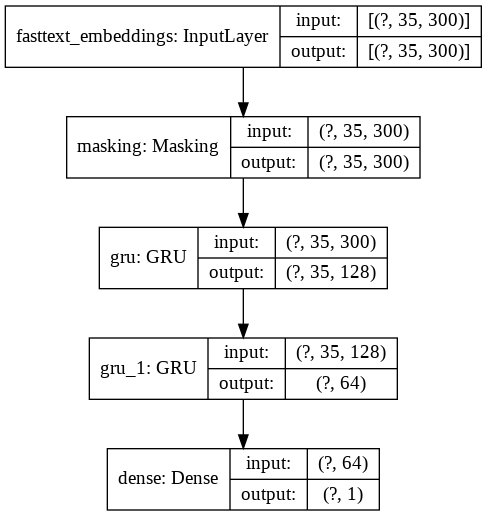

In [0]:
wv_inputs = tf.keras.Input(shape=(35,300), name='fasttext_embeddings')
x = tf.keras.layers.Masking()(wv_inputs)
x = tf.keras.layers.GRU(128, activation='relu',return_sequences = True)(x)
x = tf.keras.layers.GRU(64, activation='relu')(x)
outputs = tf.keras.layers.Dense(1,activation='sigmoid')(x)

model = tf.keras.Model(inputs=wv_inputs, outputs=outputs, name='lstm_model')

tf.keras.utils.plot_model(model, show_shapes=True)

In [0]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,clipnorm=0.5),
              metrics=['accuracy'])

history = model.fit_generator(train_gen,
                  epochs=15,validation_data=eval_gen)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/15
157/157 [==============================] - 22s 137ms/step - loss: 0.6104 - accuracy: 0.6627 - val_loss: 0.5513 - val_accuracy: 0.7240
Epoch 2/15
157/157 [==============================] - 21s 135ms/step - loss: 0.5198 - accuracy: 0.7496 - val_loss: 0.5135 - val_accuracy: 0.7474
Epoch 3/15
157/157 [==============================] - 21s 136ms/step - loss: 0.4897 - accuracy: 0.7672 - val_loss: 0.5167 - val_accuracy: 0.7578
Epoch 4/15
157/157 [==============================] - 21s 135ms/step - loss: 0.4718 - accuracy: 0.7782 - val_loss: 0.5170 - val_accuracy: 0.7552
Epoch 5/15
157/157 [==============================] - 21s 135ms/step - loss: 0.4531 - accuracy: 0.7902 - val_loss: 0.5082 - val_accuracy: 0.7656
Epoch 6/15
157/157 [==============================] - 21s 133ms/step - loss: 0.4343 - accuracy: 0.8000 - val_loss: 0.5024 - val_accuracy: 0.7552
Epoch 7/15
157/157 [==============================] - 

## Bert Finetuning

In [0]:
bert_model_finetune = ClassificationModel('bert','bert-base-uncased',args={'fp16':False})

In [0]:
bert_model_finetune.train_model(training_subset,output_dir='bert')

Running loss: 0.665434

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Running loss: 0.530247

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


Running loss: 0.415688



In [0]:
result, model_outputs, wrong_predictions = bert_model_finetune.eval_model(eval_set)

Accuracy: 0.80
Precision: 0.79
Recall: 0.83




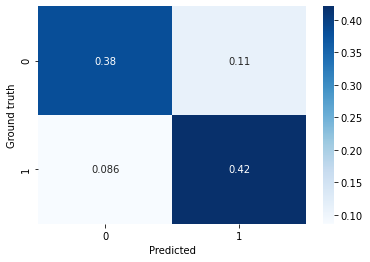

In [0]:
accuracy = (result['tn'] + result['tp'])/(result['tn'] + result['tp'] + result['fn'] + result['fp'])
precision = result['tp']/(result['tp']+result['fp'])
recall = result['tp']/(result['tp']+result['fn'])

confusion_matrix = np.array([[result['tn'],result['fp']],[result['fn'],result['tp']]])
ax = sns.heatmap(confusion_matrix/np.sum(confusion_matrix),cmap='Blues', annot=True)
ax.set(xlabel='Predicted',ylabel='Ground truth')

print("Accuracy: {:.2f}\nPrecision: {:.2f}\nRecall: {:.2f}\n\n".format(accuracy,precision,recall))

In [0]:
#@title Poniendolo a prueba
test_text = "It is a stormy day" #@param {type:"string"}


predictions, raw_outputs = bert_model_finetune.predict([test_text])

if predictions[0] == 1:
  print("Positivo: {}".format(1.0/(1.0 + np.exp(-raw_outputs[0][1]))))
else:
  print("Negativo: {}".format(1.0/(1.0 + np.exp(-raw_outputs[0][0]))))



Negativo: 0.8676336914471965
